Let's calculate the edge prior both [analytically](https://greenelab.github.io/xswap-manuscript/) and using via permuation using the [XSwap algorithm](https://hetio.github.io/xswap/prior.html).

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import seaborn as sns
import numpy as np
# from hetio.permute import permute_pair_list
import statistics
from tqdm import tqdm
import itertools

treatment_df = pd.read_csv("../data/treatment.edges.csv")

In [93]:
import random
import collections

def permute_pair_list(
    pair_list,
    directed=False,
    multiplier=10,
    excluded_pair_set=set(),
    seed=0,
    log=False,
    inplace=False,
):
    # Taken from https://github.com/hetio/hetnetpy/blob/e1ff1f8296b766dd5a63e5870a8a1a7d82427a80/hetnetpy/permute.py#L89
    """
    Permute edges (of a single type) in a graph according to the XSwap function
    described in https://doi.org/f3mn58. This method selects two edges and
    attempts to swap their endpoints. If the swap would result in a valid edge,
    the swap proceeds. Otherwise, the swap is skipped. The end result is that
    node degree is preserved, but edges are shuffled, thereby losing their
    original meaning.

    Parameters
    ----------
    pair_list : list of tuples
        List of edges to permute. Each edge is represented as a (source,
        target) tuple. source and target represent nodes and can be any Python
        objects that define __eq__. In other words, this function does not
        assume any specific format for nodes. If the edges are from a bipartite
        or directed graph, then all tuples must have the same alignment. For
        example, if the edges represent the bipartite Compound-binds-Gene
        relationship, all tuples should be of the form (compound, gene) and not
        intermixed with (gene, compound) tuples. The only instance where order
        of the source and target is not important is for an undirected edge
        type where the source and target nodes are of the same type, such as
        Gene-interacts-Gene.
    directed : bool
        Whether the edge should be considered directed. If False, a swap that
        creates an a-b edge will be invalid if a b-a edge already exists.
    multiplier : int or float
        This is multiplied by the number of edges in pair_list to determine the
        number of swaps to attempt.
    excluded_pair_set : set of tuples:
        Set of possible edges to forbid. If a swap would create an edge in this
        set, it would be considered invalid and hence skipped.
    seed : int
        Seed to initialize Python random number generator.
    log : bool
        Whether to log diagnostic INFO via python's logging module.
    inplace : bool
        Whether to modify the edge list in place.

    Returns
    -------
    pair_list : list of tuples
        The permuted edges, derived from the input pair_list.
    stats : list of dicts
        A list where each item is a dictionary of permutation statistics at a
        checkpoint. Statistics are collected at 10 checkpoints, spaced evenly
        by the number of attempts.
    """
    random.seed(seed)

    if not inplace:
        pair_list = pair_list.copy()

    pair_set = set(pair_list)
    assert len(pair_set) == len(pair_list)

    edge_number = len(pair_list)
    n_perm = int(edge_number * multiplier)

    count_same_edge = 0
    count_self_loop = 0
    count_duplicate = 0
    count_undir_dup = 0
    count_excluded = 0

    if log:
        logging.info(
            "{} edges, {} permutations (seed = {}, directed = {}, {} excluded_edges)".format(
                edge_number, n_perm, seed, directed, len(excluded_pair_set)
            )
        )

    orig_pair_set = pair_set.copy()
    step = max(1, n_perm // 10)
    print_at = list(range(step, n_perm, step)) + [n_perm - 1]

    stats = list()
    for i in range(n_perm):

        # Same two random edges
        i_0 = random.randrange(edge_number)
        i_1 = random.randrange(edge_number)

        # Same edge selected twice
        if i_0 == i_1:
            count_same_edge += 1
            continue
        pair_0 = pair_list.pop(i_0)
        pair_1 = pair_list.pop(i_1 - 1 if i_0 < i_1 else i_1)

        new_pair_0 = pair_0[0], pair_1[1]
        new_pair_1 = pair_1[0], pair_0[1]

        valid = False
        for pair in new_pair_0, new_pair_1:
            if pair[0] == pair[1]:
                count_self_loop += 1
                break  # edge is a self-loop
            if pair in pair_set:
                count_duplicate += 1
                break  # edge is a duplicate
            if not directed and (pair[1], pair[0]) in pair_set:
                count_undir_dup += 1
                break  # edge is a duplicate
            if pair in excluded_pair_set:
                count_excluded += 1
                break  # edge is excluded
        else:
            # edge passed all validity conditions
            valid = True

        # If new edges are invalid
        if not valid:
            for pair in pair_0, pair_1:
                pair_list.append(pair)

        # If new edges are valid
        else:
            for pair in pair_0, pair_1:
                pair_set.remove(pair)
            for pair in new_pair_0, new_pair_1:
                pair_set.add(pair)
                pair_list.append(pair)

        if i in print_at:
            stat = collections.OrderedDict()
            stat["cumulative_attempts"] = i
            index = print_at.index(i)
            stat["attempts"] = (
                print_at[index] + 1
                if index == 0
                else print_at[index] - print_at[index - 1]
            )
            stat["complete"] = (i + 1) / n_perm
            stat["unchanged"] = len(orig_pair_set & pair_set) / len(pair_set)
            stat["same_edge"] = count_same_edge / stat["attempts"]
            stat["self_loop"] = count_self_loop / stat["attempts"]
            stat["duplicate"] = count_duplicate / stat["attempts"]
            stat["undirected_duplicate"] = count_undir_dup / stat["attempts"]
            stat["excluded"] = count_excluded / stat["attempts"]
            stats.append(stat)

            count_same_edge = 0
            count_self_loop = 0
            count_duplicate = 0
            count_undir_dup = 0
            count_excluded = 0

    assert len(pair_set) == edge_number
    return pair_list, stats

In [94]:
def _get_prior_perm_analytical(u,v,m):
    return u*v / np.sqrt((u*v)**2 + (m - u - v + 1)**2)

def get_prior_perm(treatment_df):
    # Taken from https://github.com/dhimmel/learn/blob/a7766ea00da67f5cf03bd77e6e613a262918f1b8/prior/1-prior.ipynb
    source_degree = dict(treatment_df.source_id.value_counts())
    target_degree = dict(treatment_df.target_id.value_counts())
    treatment_df['source_degree'] = treatment_df.source_id.apply(source_degree.get)
    treatment_df['target_degree'] = treatment_df.target_id.apply(target_degree.get)
    num_edges = len(treatment_df)
    treatment_df['prior_perm_analytical'] = treatment_df.apply(lambda row: _get_prior_perm_analytical(row.source_degree, row.target_degree, num_edges), axis=1)
    
    treatments = list(zip(treatment_df.source_id, treatment_df.target_id))
    pair_list, stats = permute_pair_list(treatments)
    
    # A degree (source_degree, target_degree) to all potential edges with that degree
    degree_to_edges = dict()
    rows = list()
    for (c, c_deg), (d, d_deg) in itertools.product(source_degree.items(), target_degree.items()):
        rows.append((c, d, c_deg, d_deg))
        degree = c_deg, d_deg
        edge = c, d
        degree_to_edges.setdefault(degree, set()).add(edge)
        
    # Initialize a dictionary of degree to empirical probability list
    degree_to_probs = {x: list() for x in degree_to_edges}
    
    # Set the multiplier based on the burn in stats
    multiplier = 0.001
    n_perm = treatment_df.source_id.nunique() * treatment_df.target_id.nunique()
    
    # Perform n_perm permutations
    for i in tqdm(np.arange(n_perm*multiplier)):
        # Permute
        pair_list, stats = permute_pair_list(pair_list, multiplier=multiplier, seed=i)

        currrent_num_unchanged_edges = pd.DataFrame(stats).unchanged.iloc[-1]
        pair_set = set(pair_list)
        for degree, probs in degree_to_probs.items():
            edges = degree_to_edges[degree]
            probs.append(len(edges & pair_set) / len(edges))
        
    for (c_deg, d_deg), probs in degree_to_probs.items():
        mean = statistics.mean(probs)
        std_error = statistics.stdev(probs) / len(probs) ** 0.5
        rows.append((c_deg, d_deg, mean, std_error))
    perm_df = pd.DataFrame(rows, columns=['source_degree', 'target_degree', 'prior_perm', 'prior_perm_stderr'])
    perm_df = perm_df.sort_values(['source_degree', 'target_degree'])
    
    # Add unpermuted treatment prevalence columns
    rows = list()
    treatment_set = set(treatments)
    for (c_deg, d_deg), edges in degree_to_edges.items():
        n_treatments = len(edges & treatment_set)
        rows.append((c_deg, d_deg, n_treatments, len(edges)))
    degree_prior_df = pd.DataFrame(rows, columns=['source_degree', 'target_degree', 'n_treatments', 'n_possible'])
    degree_prior_df = perm_df.merge(degree_prior_df)
    degree_prior_df = degree_prior_df.sort_values(['source_degree', 'target_degree'])
    degree_prior_df = degree_prior_df.groupby(['source_degree','target_degree'])['prior_perm'].mean().reset_index()
    treatment_df = treatment_df.merge(degree_prior_df, how="inner")

    return treatment_df


In [95]:
treatment_df = get_prior_perm(treatment_df)
treatment_df.to_csv("../data/treatment.edges.csv", index=False)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 2653/2653 [04:36<00:00,  9.58it/s]


Excellent - all methods agree that we can't predict treatment edges purely via connectivity.

<Axes: xlabel='target_degree'>

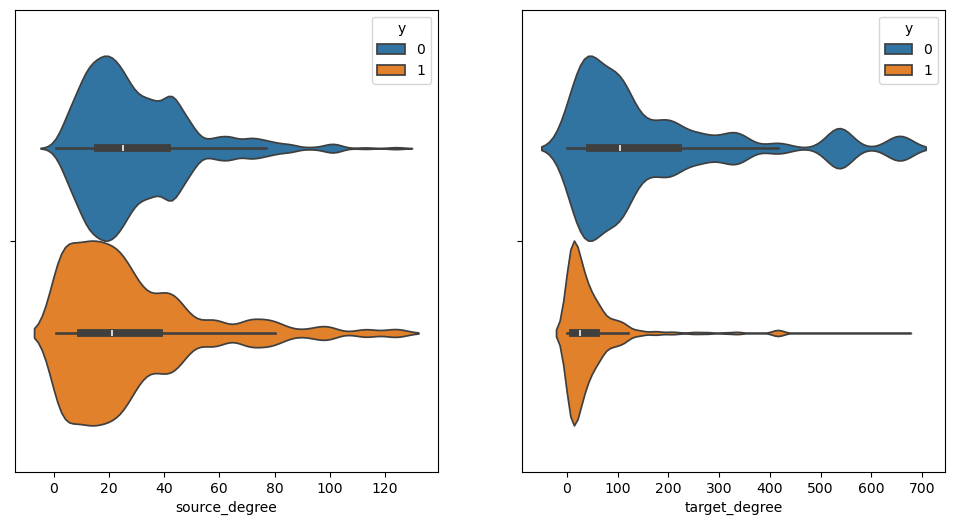

In [96]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.violinplot(data=treatment_df,hue='y', x='source_degree', ax=axes[0])
sns.violinplot(data=treatment_df,hue='y', x='target_degree', ax=axes[1])

In [97]:
print("Analytical prior:", roc_auc_score(treatment_df.y, treatment_df.prior_perm_analytical))
print("Permuation prior:", roc_auc_score(treatment_df.y, treatment_df.prior_perm))

Analytical prior: 0.18453131166096537
Permuation prior: 0.1964977844567033


<Axes: xlabel='prior_perm'>

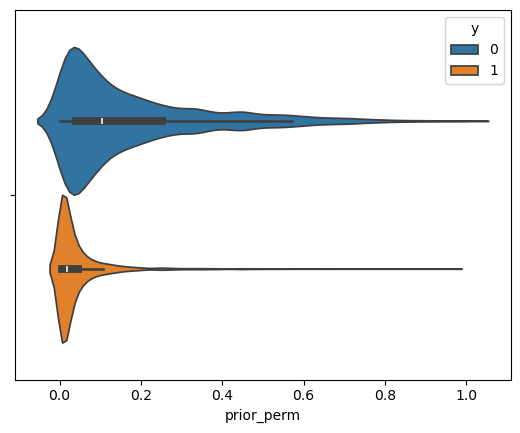

In [98]:
sns.violinplot(data=treatment_df, x='prior_perm', hue='y')

<Axes: xlabel='prior_perm_analytical', ylabel='prior_perm'>

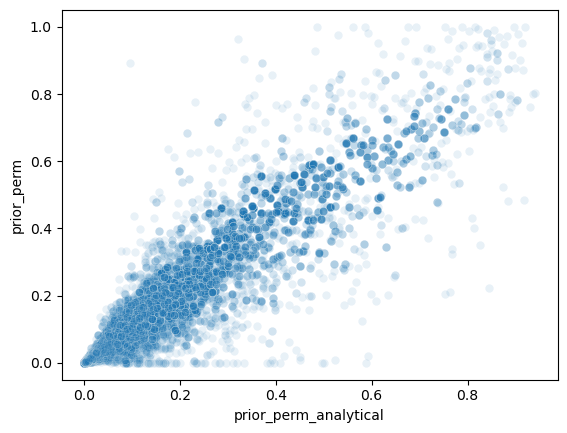

In [99]:
sns.scatterplot(data=treatment_df, x='prior_perm_analytical',y='prior_perm', alpha=0.1)